## 0. Intro

### Importamos algunos paquetes

In [2]:
import sklearn
import numpy as np
import os

np.random.seed(11)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


## Datos

#### Importamos las fotos desde el pickle

In [3]:
import pickle
with open('faces_dict.p', 'rb') as handle:
        faces = pickle.load(handle)

##### De la exploración de datos realizada previamente, sabemos que los datos consisten en 400 fotografías correspondientes a 40 personas distintas. Para cara persona, contamos con 10 fotografías que difieren entre sí en aspectos como la orientación de la cara, el uso o no de lentes, gestos faciales, entre otros.

##### De las 10 caras de cada persona, realizamos una partición (6,2,2) = (train,validación,test). Para ello utilizamos muestreo aleatorio y estratificado:

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
valisize=80
testsize=80
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=testsize, random_state=11)
train_val_idx, test_idx = next(strat_split.split(faces['data'], faces['target']))
X_train_val = faces['data'][train_val_idx]
y_train_val = faces['target'][train_val_idx]
X_test = faces['data'][test_idx]
y_test = faces['target'][test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=valisize, random_state=12)
train_idx, valid_idx = next(strat_split.split(X_train_val, y_train_val))
X_train = X_train_val[train_idx]
y_train = y_train_val[train_idx]
X_val = X_train_val[valid_idx]
y_val = y_train_val[valid_idx]

#### Observamos los datos de entrenamiento y de validación.
Cada una de las filas de fotos corresponde a una misma persona.

Dentro de cada fila, las fotos en blanco y negro corresponden a los datos de entrenamiento X_train.

Las fotos coloreadas de azul corresponden a los datos de validación X_val

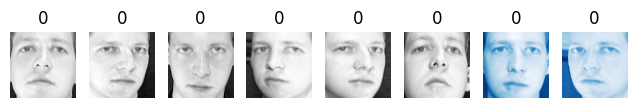

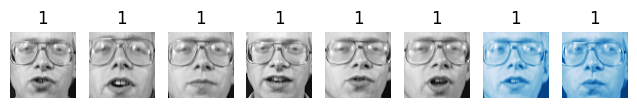

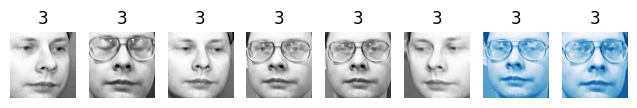

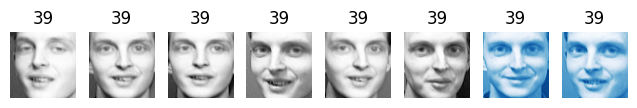

In [5]:

def plot_faces(faces, labels, n_cols=10):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        cmap0 = "Greys_r"
        if (index > 5):
            cmap0 = "Blues_r"
        plt.imshow(face, cmap=cmap0)
        plt.axis("off")
        plt.title(label)

y_show = np.append(y_train,y_val)
X_show = np.append(X_train, X_val).reshape(400-testsize,4096)

for cluster_id in [0,1,3,39]:
    in_cluster = y_show ==cluster_id
    faces = X_show[in_cluster]
    labels = y_show[in_cluster]
    plot_faces(faces, labels)
plt.show()

Como filosofía de trabajo no utilizaremos ni observaremos la partición de test hasta contar con los modelos finales

---

## 1. Modelo "baseline" de ML (PCA + LogisticRegression)

    1.a Exploración asociada a la reducción de dimensionalidad (PCA)
    1.b Observación del problema en el espacio de autovalores y autovectores. Evaluación inicial del modelo.
    1.c Data Augmentation.
    1.d Análisis de regularización.
    1.e Análisis de sensibilidad (cross-validación por Monte Carlo).
    1.f Selección final del modelo.


---

    1.a Exploración asociada a la reducción de dimensionalidad (PCA)

- Analizamos la posibilidad de realizar una reducción de la dimensionalidad con PCA (Principal Component Analysis) y luego hacer una regresión logística de los datos con dimensionalidad reducida.
- En primer lugar, exploramos los errores de train y test cuando variamos la dimensionalidad de salida del PCA y utilizando sklearn.linear_model.LogisticRegression con sus parámetros default (excepto max_iter=2500)

In [6]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *

logreg = LogisticRegression(max_iter=2500)

comps   = []
e_train = []
e_val   = []

for i in range(2,40,1):
    comps.append(i)
    pca = PCA(n_components=i)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    model_log = logreg.fit(X_train_pca,y_train)
    y_predicted_train = model_log.predict(X_train_pca)
    y_predicted_val = model_log.predict(X_val_pca)
    e_train.append(1-accuracy_score(y_train,y_predicted_train))
    e_val.append(1-accuracy_score(y_val,y_predicted_val))



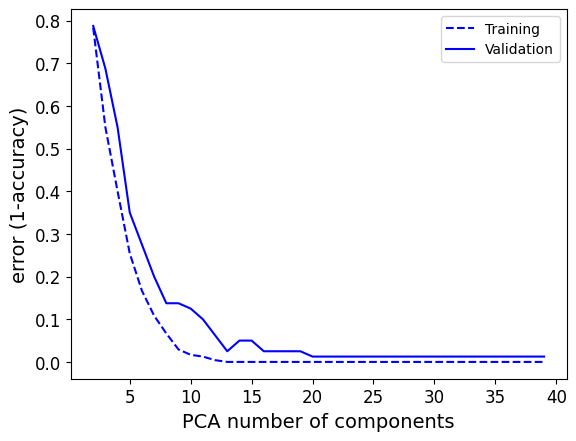

In [7]:

from sklearn.preprocessing import scale


plt.plot(comps,e_train,'--',color='b', label='Training')
plt.plot(comps,e_val,color='b',label='Validation')
plt.xlabel('PCA number of components')
plt.ylabel('error (1-accuracy)')
plt.legend()

- De acuerdo al gráfico anterior, consideramos que un número de 30 componentes es suficiente para clasificar las imágenes.
- Además, podemos ver que la exactitud (accuracy) del modelo inicial planteado es muy buena. En particular, para n_components=30:

---

    1.b Observación del problema en el espacio de autovalores y autovectores. Evaluación inicial del modelo.

In [8]:
pca = PCA(n_components=30)

X_train_pca = pca.fit_transform(X_train)
X_val_pca   = pca.transform(X_val)
X_test_pca  = pca.transform(X_test)

model_log = logreg.fit(X_train_pca,y_train)

y_predicted_train = model_log.predict(X_train_pca)
y_predicted_val = model_log.predict(X_val_pca)

print("Training accuracy: ",accuracy_score(y_train,y_predicted_train))
print("Validation accuracy: ",accuracy_score(y_val,y_predicted_val))

Training accuracy:  1.0
Validation accuracy:  0.9875


#### Eigenfaces

- Por curiosidad, muestro las 30 "autocaras" del problema

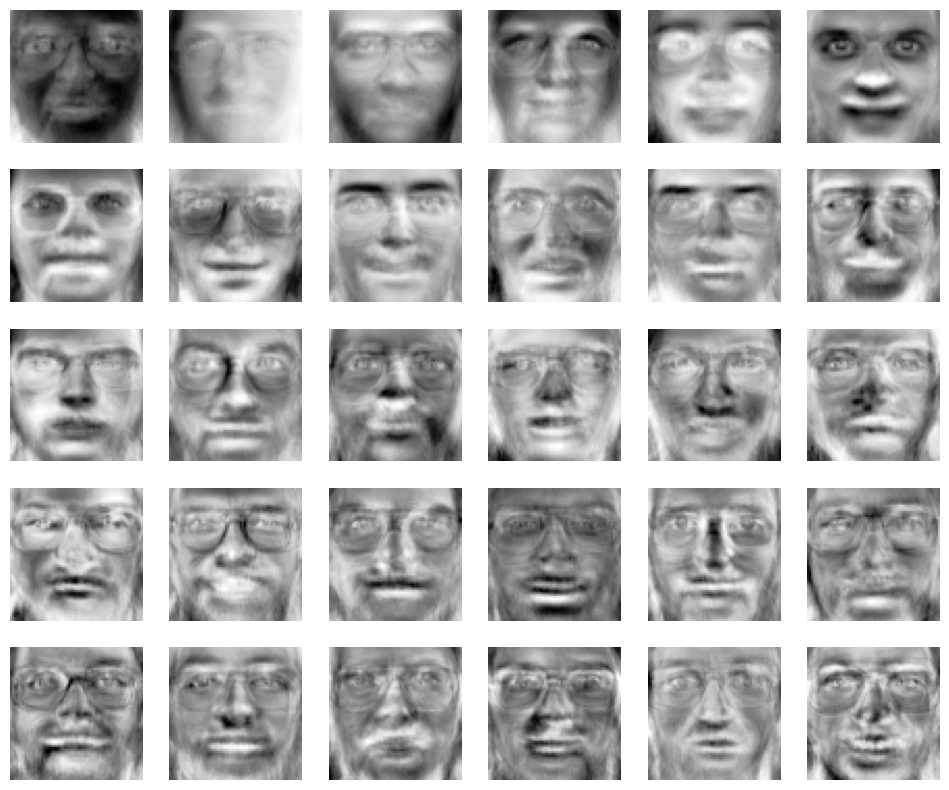

In [9]:
pca = PCA(n_components=30).fit(X_train)
eigenfaces = pca.components_

def plot_faces(faces, n_cols=6):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols*2, n_rows*2))
    for index, (face, face) in enumerate(zip(faces, faces)):
        plt.subplot(n_rows, n_cols, index + 1)
        cmap0 = "Greys_r"
        plt.imshow(face, cmap=cmap0)
        plt.axis("off")

plot_faces(eigenfaces)

#### Note: eigenfaces are creepy

- Investigamos el espacio de autovalores asociados, e identificamos los errores de clasificación en este espacio.

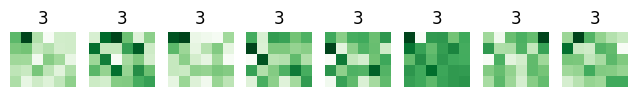

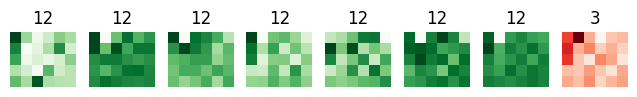

In [10]:

def plot_faces(faces, labels, pred_labels, n_cols=10):
    faces = faces.reshape(-1, 5, 6)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, (face, label, real_label) in enumerate(zip(faces, labels,pred_labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        if (label==real_label):
            cmap0 = "Greens_r"
        else:
            cmap0 = "Reds_r"
        plt.imshow(face, cmap=cmap0)
        plt.axis("off")
        plt.title(real_label)

y_show = np.append(y_train,y_val)
y_out  = np.append(y_predicted_train,y_predicted_val)
X_show = np.append(X_train_pca, X_val_pca).reshape(400-testsize,30)

for cluster_id in [3,12]:
    in_cluster = (y_show == cluster_id)
    faces = X_show[in_cluster]
    real_labels = y_show[in_cluster]
    pred_labels = y_out[in_cluster]
    plot_faces(faces, real_labels, pred_labels)


- Nuevamente en el espacio de caras ...

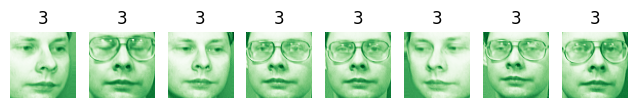

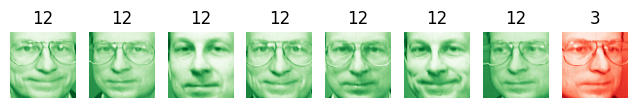

In [11]:

def plot_faces(faces, labels, pred_labels, n_cols=10):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows))
    for index, (face, label, real_label) in enumerate(zip(faces, labels,pred_labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        if (label==real_label):
            cmap0 = "Greens_r"
        else:
            cmap0 = "Reds_r"
        plt.imshow(face, cmap=cmap0)
        plt.axis("off")
        plt.title(real_label)

y_show = np.append(y_train,y_val)
y_out  = np.append(y_predicted_train,y_predicted_val)
X_show = np.append(X_train, X_val).reshape(400-testsize,64*64)

for cluster_id in [3,12]:
    in_cluster = (y_show == cluster_id)
    faces = X_show[in_cluster]
    real_labels = y_show[in_cluster]
    pred_labels = y_out[in_cluster]
    plot_faces(faces, real_labels, pred_labels)
plt.show()

- Notamos que la exactitud es 79 correctos / 80 pruebas

In [12]:
79/80

0.9875

---

    1.c Data Augmentation.

In [3]:
# example of horizontal shift image augmentation
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

# load the image
img = X_train[34].reshape(1,64,64,1)

# create image data augmentation generator
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=3,
    width_shift_range=3,
    height_shift_range=4,
    brightness_range=[0.1,0.2],
    shear_range=0.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=0.1,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    dtype=None
)


# prepare iterator
it = datagen.flow(img, batch_size=100,seed=2)
# generate samples and plot
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# generate batch of images
	batch = it.next()
	# convert to unsigned integers for viewing
	image = batch[0]
	# plot raw pixel data
	pyplot.imshow(image,cmap='Greys_r')
	plt.axis("off")
# show the figure
pyplot.show()

NameError: name 'X_train' is not defined

- Aumentamos los datos de entrenamiento, generando N imágenes por cada una de las fotografías originales

In [14]:
X_train_augmented=[]
y_train_augmented=[]
N=3

for i in range(0,len(y_train),1):
    img = X_train[i].reshape(1,64,64,1)
    it = datagen.flow(img, batch_size=100,seed=i)
    X_train_augmented.append(X_train[i]) # La imagen original queda
    y_train_augmented.append(y_train[i]) # ...y su etiqueta
    for j in range(0,N,1):
        batch = it.next()
        image = batch[0]
        image = image.reshape(4096)
        X_train_augmented.append(image) # Agregamos la imagen modificada
        y_train_augmented.append(y_train[i]) # ... con la misma etiqueta

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


In [15]:
X_train_augmented.shape

(960, 4096)

In [16]:
y_train_augmented.shape

(960,)

- Reentrenamos el modelo

In [17]:
logreg = LogisticRegression(max_iter=55000)
pca = PCA(n_components=30)

X_train_pca_augmented = pca.fit_transform(X_train_augmented)
X_val_pca = pca.transform(X_val)
X_test_2 = pca.transform(X_test)

model_log = logreg.fit(X_train_pca_augmented,y_train_augmented)

y_predicted_train = model_log.predict(X_train_pca_augmented)
y_predicted_val = model_log.predict(X_val_pca)

- Classification report del nuevo modelo

In [18]:
print("Training accuracy: ",accuracy_score(y_train_augmented,y_predicted_train))
print("Validation accuracy: ",accuracy_score(y_val,y_predicted_val))

print(sklearn.metrics.classification_report(y_val,y_predicted_val,digits=4))

Training accuracy:  0.26875
Validation accuracy:  0.9875
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         2
           3     0.6667    1.0000    0.8000         2
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         2
           6     1.0000    1.0000    1.0000         2
           7     1.0000    1.0000    1.0000         2
           8     1.0000    1.0000    1.0000         2
           9     1.0000    1.0000    1.0000         2
          10     1.0000    1.0000    1.0000         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    0.5000    0.6667         2
          13     1.0000    1.0000    1.0000         2
          14     1.0000    1.0000    1.0000         2
          15     1.0000    1.0000    1.0000         2
          16     1.0000 

---

    1.d Regularización / tuning

- Investigamos los tipos de regularización (L2, L1) y el parámetro C (inversa de la intensidad de la regularización). La regularización L2 la exploramos con los solvers _default_ y 'saga'. L1 sólo con 'saga'

In [19]:
train_acc_l1=[]
val_acc_l1=[]
cvalues=[0.025,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]
for C in cvalues:
    logreg = LogisticRegression(max_iter=55000,C=C,penalty='l1',solver='saga')

    model_log = logreg.fit(X_train_pca_augmented,y_train_augmented)

    y_predicted_train = model_log.predict(X_train_pca_augmented)
    y_predicted_val = model_log.predict(X_val_pca)
    train_acc_l1.append(accuracy_score(y_train_augmented,y_predicted_train))
    val_acc_l1.append(accuracy_score(y_val,y_predicted_val))



In [20]:
train_acc_l2=[]
val_acc_l2=[]
cvalues=[0.025,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]
for C in cvalues:
    logreg = LogisticRegression(max_iter=5500,C=C,penalty='l2',solver='saga')

    model_log = logreg.fit(X_train_pca_augmented,y_train_augmented)

    y_predicted_train = model_log.predict(X_train_pca_augmented)
    y_predicted_val = model_log.predict(X_val_pca)
    train_acc_l2.append(accuracy_score(y_train_augmented,y_predicted_train))
    val_acc_l2.append(accuracy_score(y_val,y_predicted_val))

In [21]:
train_acc_l2_new=[]
val_acc_l2_new=[]
cvalues=[0.025,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]
for C in cvalues:
    logreg = LogisticRegression(max_iter=5500,C=C)

    model_log = logreg.fit(X_train_pca_augmented,y_train_augmented)

    y_predicted_train = model_log.predict(X_train_pca_augmented)
    y_predicted_val = model_log.predict(X_val_pca)
    train_acc_l2_new.append(accuracy_score(y_train_augmented,y_predicted_train))
    val_acc_l2_new.append(accuracy_score(y_val,y_predicted_val))

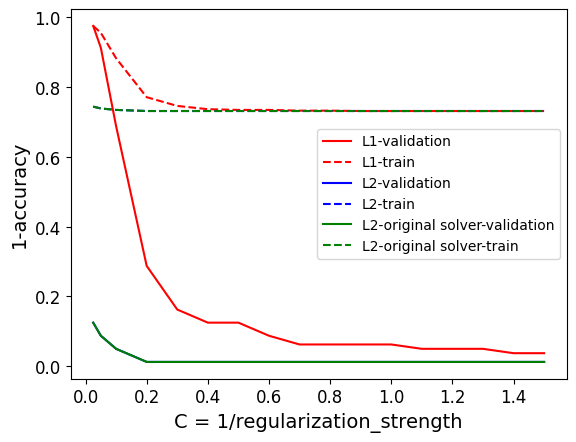

In [22]:
plt.xlabel("C = 1/regularization_strength")
plt.ylabel("1-accuracy")
plt.plot(cvalues,np.ones(len(cvalues))-val_acc_l1,c='red',label="L1-validation")
plt.plot(cvalues,np.ones(len(cvalues))-train_acc_l1,c='red',label="L1-train",linestyle='--')
plt.plot(cvalues,np.ones(len(cvalues))-val_acc_l2,c='blue',label="L2-validation")
plt.plot(cvalues,np.ones(len(cvalues))-train_acc_l2,c='blue',label="L2-train",linestyle='--')
plt.plot(cvalues,np.ones(len(cvalues))-val_acc_l2_new,c='green',label="L2-original solver-validation")
plt.plot(cvalues,np.ones(len(cvalues))-train_acc_l2_new,c='green',label="L2-original solver-train",linestyle='--')
plt.legend()

- Decidimos no cambiar las opciones de solver y de regularización respecto a las _default_

In [23]:
logreg = LogisticRegression(max_iter=5500)
model_pcalog = logreg.fit(X_train_pca_augmented,y_train_augmented)

---

    1.e Análisis de sensibilidad (cross-validación por Monte Carlo).

In [24]:
tr_acc_cv=[]
va_acc_cv=[]

for i in range(0,20,1):
    strat_split = StratifiedShuffleSplit(n_splits=1, test_size=valisize, random_state=200+i)
    train_idx, valid_idx = next(strat_split.split(X_train_val, y_train_val))
    X_train_i = X_train_val[train_idx]
    y_train_i = y_train_val[train_idx]
    X_val_i = X_train_val[valid_idx]
    y_val_i = y_train_val[valid_idx]

    X_train_augmented_i=[]
    y_train_augmented_i=[]
    N=3

    for i in range(0,len(y_train),1):
        img = X_train_i[i].reshape(1,64,64,1)
        it = datagen.flow(img, batch_size=100,seed=i)
        X_train_augmented_i.append(X_train_i[i]) # La imagen original queda
        y_train_augmented_i.append(y_train_i[i]) # ...y su etiqueta
        for j in range(0,N,1):
            batch = it.next()
            image = batch[0]
            image = image.reshape(4096)
            X_train_augmented_i.append(image) # Agregamos la imagen modificada
            y_train_augmented_i.append(y_train_i[i]) # ... con la misma etiqueta

    X_train_augmented_i = np.array(X_train_augmented_i)
    y_train_augmented_i = np.array(y_train_augmented_i)


    X_train_pca_i = pca.fit_transform(X_train_augmented_i)
    X_val_pca_i   = pca.transform(X_val_i)

    model_log = logreg.fit(X_train_pca_i,y_train_augmented_i)

    y_predicted_train_i = model_log.predict(X_train_pca_i)
    y_predicted_val_i = model_log.predict(X_val_pca_i)

    tr_acc_cv.append(accuracy_score(y_train_augmented_i,y_predicted_train_i))
    va_acc_cv.append(accuracy_score(y_val_i,y_predicted_val_i))


In [25]:
print("training accuracy:",np.round(np.mean(tr_acc_cv),3),"+/-",np.round(np.std(tr_acc_cv),3))
print("validation accuracy:",np.round(np.mean(va_acc_cv),2),"+/-",np.round(np.std(va_acc_cv),2))

training accuracy: 0.269 +/- 0.0
validation accuracy: 0.94 +/- 0.02


---

    1.f Selección final del modelo.

### Exporto el modelo en un pickle

In [26]:
with open("model_log.pkl","wb") as f:
    pickle.dump(model_pcalog,f)

---

## 2. Modelo utilizando ConvNets
    2.a Exploración de la arquitectura de la red y opciones de filtros.
    2.b Análisis de regularización.
    2.c Utilizando CNN pre-entrenada.


---

Adaptamos el formato de los datos

In [1]:
X_train_convnet = X_train_augmented.reshape(X_train_augmented.shape[0],64,64,1)
X_val_convnet = X_val.reshape(X_val.shape[0],64,64,1)
X_test_convnet = X_test.reshape(X_test.shape[0],64,64,1)

from tensorflow.keras.utils import to_categorical

# pasamos las categorías a one-hot encoder
y_train_convnet = to_categorical(y_train_augmented)
y_val_convnet = to_categorical(y_val)
y_test_convnet = to_categorical(y_test)

NameError: name 'X_train_augmented' is not defined

    2.a Exploración de la arquitectura de la red y opciones de filtros.     

Comenzamos utilizando una convnet básica, utilizado el set aumentado de training.

In [28]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout

# creamos el modelo
model1 = Sequential()
# agregamos capas
model1.add(Conv2D(64, kernel_size=8, activation="relu"))
model1.add(Conv2D(32, kernel_size=2, activation="relu"))
model1.add(Flatten())
model1.add(Dense(40, activation="softmax"))

In [29]:
# compilamos
from tabnanny import verbose

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
import tensorflow as tf
# entrenamos el modelo
tf.random.set_seed(111)
history = model1.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=30,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']




Epoch 1/30
30/30 - 6s - loss: 3.8020 - accuracy: 0.0219 - val_loss: 3.6889 - val_accuracy: 0.0250 - 6s/epoch - 185ms/step
Epoch 2/30
30/30 - 4s - loss: 3.6892 - accuracy: 0.0188 - val_loss: 3.6889 - val_accuracy: 0.0250 - 4s/epoch - 149ms/step
Epoch 3/30
30/30 - 4s - loss: 3.6894 - accuracy: 0.0156 - val_loss: 3.6883 - val_accuracy: 0.0375 - 4s/epoch - 140ms/step
Epoch 4/30
30/30 - 4s - loss: 3.6896 - accuracy: 0.0167 - val_loss: 3.6888 - val_accuracy: 0.0250 - 4s/epoch - 144ms/step
Epoch 5/30
30/30 - 4s - loss: 3.6893 - accuracy: 0.0208 - val_loss: 3.6889 - val_accuracy: 0.0250 - 4s/epoch - 141ms/step
Epoch 6/30
30/30 - 4s - loss: 3.6892 - accuracy: 0.0198 - val_loss: 3.6889 - val_accuracy: 0.0250 - 4s/epoch - 143ms/step
Epoch 7/30
30/30 - 4s - loss: 3.6892 - accuracy: 0.0177 - val_loss: 3.6889 - val_accuracy: 0.0250 - 4s/epoch - 141ms/step
Epoch 8/30
30/30 - 4s - loss: 3.6892 - accuracy: 0.0208 - val_loss: 3.6889 - val_accuracy: 0.0250 - 4s/epoch - 141ms/step
Epoch 9/30
30/30 - 4s - 

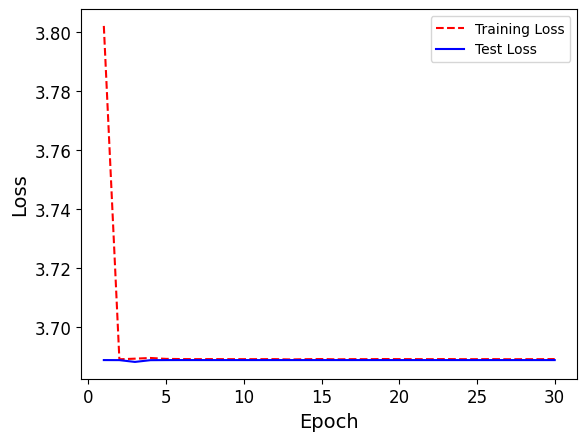

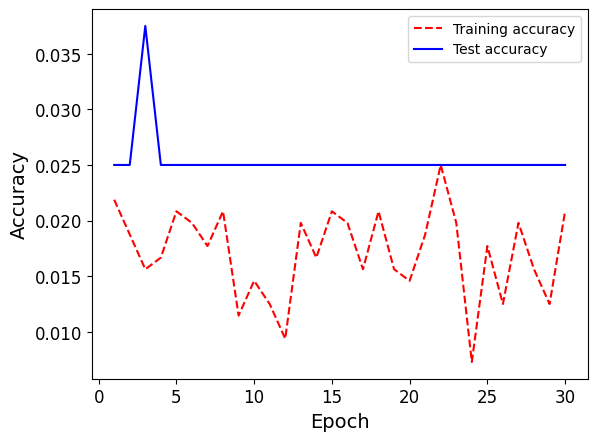

In [31]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Variamos la arquitectura invirtiendo la candidad de filtros en las dos capas

In [32]:
# creamos el modelo
model2 = Sequential()
# agregamos capas
model2.add(Conv2D(32, kernel_size=8, activation="relu"))
model2.add(Conv2D(64, kernel_size=2, activation="relu"))
model2.add(Flatten())
model2.add(Dense(40, activation="softmax"))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model2.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=30,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

Epoch 1/30
30/30 - 6s - loss: 4.2637 - accuracy: 0.0271 - val_loss: 3.7189 - val_accuracy: 0.0250 - 6s/epoch - 201ms/step
Epoch 2/30
30/30 - 5s - loss: 3.6841 - accuracy: 0.0417 - val_loss: 3.4599 - val_accuracy: 0.1875 - 5s/epoch - 181ms/step
Epoch 3/30
30/30 - 5s - loss: 3.5673 - accuracy: 0.0823 - val_loss: 2.8160 - val_accuracy: 0.3500 - 5s/epoch - 167ms/step
Epoch 4/30
30/30 - 5s - loss: 3.2723 - accuracy: 0.1510 - val_loss: 1.7299 - val_accuracy: 0.6000 - 5s/epoch - 169ms/step
Epoch 5/30
30/30 - 5s - loss: 2.9820 - accuracy: 0.2104 - val_loss: 1.1350 - val_accuracy: 0.6875 - 5s/epoch - 167ms/step
Epoch 6/30
30/30 - 5s - loss: 2.8649 - accuracy: 0.2490 - val_loss: 0.4418 - val_accuracy: 0.9125 - 5s/epoch - 166ms/step
Epoch 7/30
30/30 - 5s - loss: 2.7924 - accuracy: 0.2583 - val_loss: 0.4730 - val_accuracy: 0.8625 - 5s/epoch - 164ms/step
Epoch 8/30
30/30 - 5s - loss: 2.7846 - accuracy: 0.2635 - val_loss: 0.3810 - val_accuracy: 0.9000 - 5s/epoch - 166ms/step
Epoch 9/30
30/30 - 5s - 

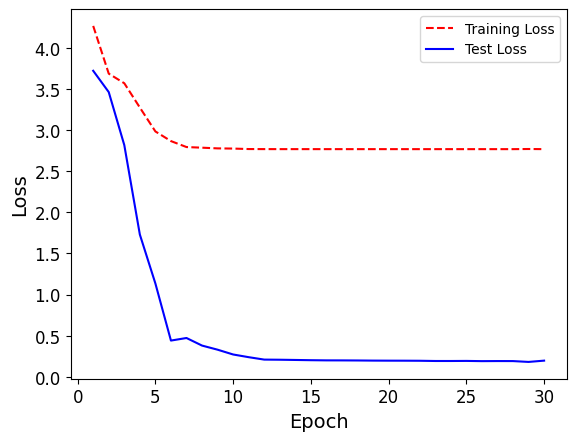

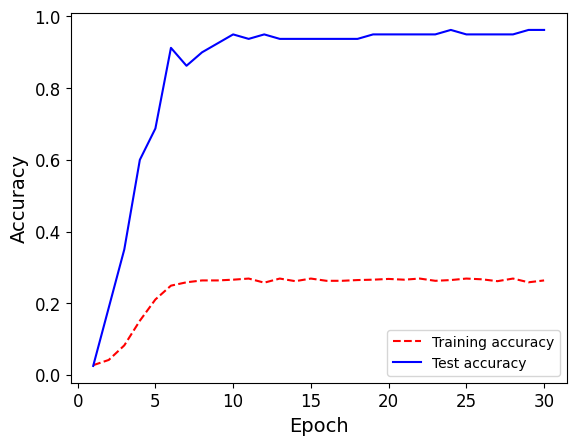

In [33]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Agregamos una capa de pooling a la salida de las capas convolucionales

In [34]:
# creamos el modelo
model3 = Sequential()
# agregamos capas
model3.add(Conv2D(32, kernel_size=8, activation="relu"))
model3.add(Conv2D(64, kernel_size=2, activation="relu"))
model3.add(MaxPool2D(pool_size=4))
model3.add(Flatten())
model3.add(Dense(40, activation="softmax"))

model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model3.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=30,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']


Epoch 1/30
30/30 - 4s - loss: 3.7026 - accuracy: 0.0188 - val_loss: 3.6822 - val_accuracy: 0.0750 - 4s/epoch - 142ms/step
Epoch 2/30
30/30 - 3s - loss: 3.6873 - accuracy: 0.0271 - val_loss: 3.6538 - val_accuracy: 0.1750 - 3s/epoch - 108ms/step
Epoch 3/30
30/30 - 4s - loss: 3.6701 - accuracy: 0.0406 - val_loss: 3.4963 - val_accuracy: 0.2250 - 4s/epoch - 126ms/step
Epoch 4/30
30/30 - 3s - loss: 3.5640 - accuracy: 0.1031 - val_loss: 2.6230 - val_accuracy: 0.4625 - 3s/epoch - 112ms/step
Epoch 5/30
30/30 - 3s - loss: 3.1932 - accuracy: 0.1844 - val_loss: 1.2716 - val_accuracy: 0.7125 - 3s/epoch - 104ms/step
Epoch 6/30
30/30 - 3s - loss: 2.9015 - accuracy: 0.2427 - val_loss: 0.5707 - val_accuracy: 0.9000 - 3s/epoch - 113ms/step
Epoch 7/30
30/30 - 4s - loss: 2.8022 - accuracy: 0.2625 - val_loss: 0.2823 - val_accuracy: 0.9625 - 4s/epoch - 118ms/step
Epoch 8/30
30/30 - 3s - loss: 2.7801 - accuracy: 0.2667 - val_loss: 0.1949 - val_accuracy: 0.9750 - 3s/epoch - 106ms/step
Epoch 9/30
30/30 - 3s - 

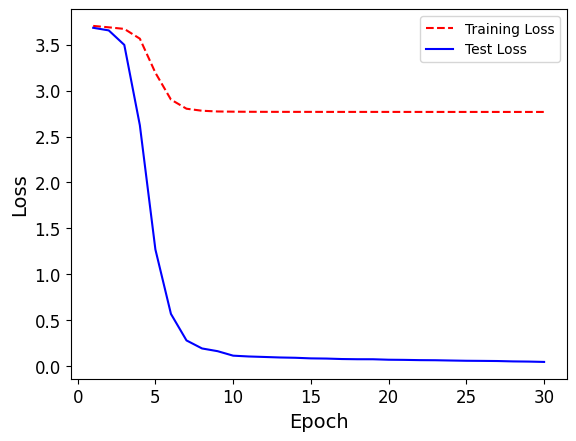

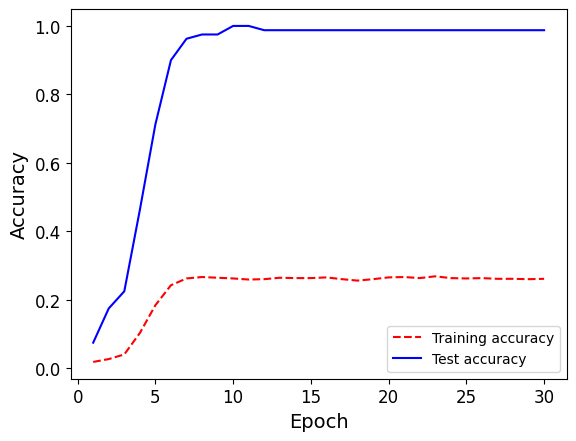

In [35]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Kernels más pequeños en cada filtro

In [36]:
# creamos el modelo
model4 = Sequential()
# agregamos capas
model4.add(Conv2D(32, kernel_size=2, activation="relu"))
model4.add(Conv2D(64, kernel_size=4, activation="relu"))
model4.add(MaxPool2D(pool_size=4))
model4.add(Flatten())
model4.add(Dense(40, activation="softmax"))

model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model4.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=30,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']


Epoch 1/30
30/30 - 7s - loss: 3.7001 - accuracy: 0.0198 - val_loss: 3.6697 - val_accuracy: 0.2625 - 7s/epoch - 239ms/step
Epoch 2/30
30/30 - 6s - loss: 3.6767 - accuracy: 0.0500 - val_loss: 3.6021 - val_accuracy: 0.1000 - 6s/epoch - 198ms/step
Epoch 3/30
30/30 - 8s - loss: 3.6377 - accuracy: 0.0750 - val_loss: 3.3653 - val_accuracy: 0.1500 - 8s/epoch - 257ms/step
Epoch 4/30
30/30 - 7s - loss: 3.5292 - accuracy: 0.1396 - val_loss: 2.7600 - val_accuracy: 0.6125 - 7s/epoch - 237ms/step
Epoch 5/30
30/30 - 6s - loss: 3.2945 - accuracy: 0.2094 - val_loss: 1.7866 - val_accuracy: 0.7375 - 6s/epoch - 202ms/step
Epoch 6/30
30/30 - 6s - loss: 3.0227 - accuracy: 0.2448 - val_loss: 0.9420 - val_accuracy: 0.9125 - 6s/epoch - 186ms/step
Epoch 7/30
30/30 - 5s - loss: 2.8616 - accuracy: 0.2583 - val_loss: 0.5425 - val_accuracy: 0.9625 - 5s/epoch - 154ms/step
Epoch 8/30
30/30 - 4s - loss: 2.8050 - accuracy: 0.2646 - val_loss: 0.3797 - val_accuracy: 0.9500 - 4s/epoch - 150ms/step
Epoch 9/30
30/30 - 5s - 

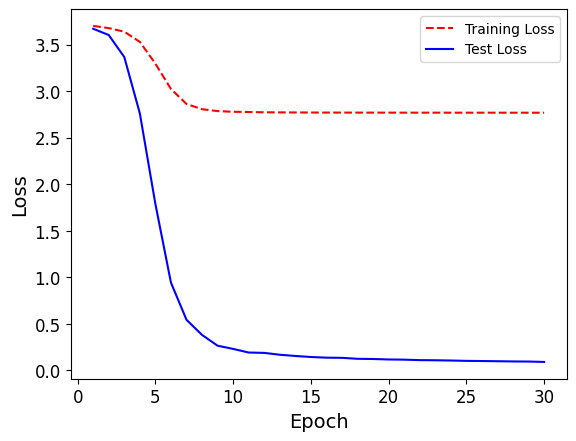

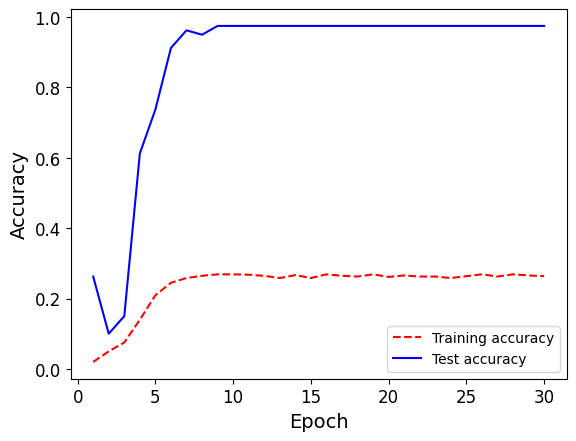

In [37]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Añadimos padding "same" con strides = 1

In [38]:
# creamos el modelo
model5 = Sequential()
# agregamos capas
model5.add(Conv2D(32, kernel_size=2,padding="same",strides=1, activation="relu"))
model5.add(Conv2D(64, kernel_size=4,padding="same",strides=1, activation="relu"))
model5.add(MaxPool2D(pool_size=4))
model5.add(Flatten())
model5.add(Dense(40, activation="softmax"))

model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model5.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=30,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

Epoch 1/30
30/30 - 7s - loss: 3.6959 - accuracy: 0.0240 - val_loss: 3.6877 - val_accuracy: 0.0625 - 7s/epoch - 227ms/step
Epoch 2/30
30/30 - 6s - loss: 3.6892 - accuracy: 0.0281 - val_loss: 3.6821 - val_accuracy: 0.1125 - 6s/epoch - 205ms/step
Epoch 3/30
30/30 - 5s - loss: 3.6835 - accuracy: 0.0281 - val_loss: 3.6278 - val_accuracy: 0.0375 - 5s/epoch - 174ms/step
Epoch 4/30
30/30 - 5s - loss: 3.6650 - accuracy: 0.0437 - val_loss: 3.5311 - val_accuracy: 0.0375 - 5s/epoch - 183ms/step
Epoch 5/30
30/30 - 6s - loss: 3.5985 - accuracy: 0.0656 - val_loss: 3.0754 - val_accuracy: 0.3875 - 6s/epoch - 198ms/step
Epoch 6/30
30/30 - 6s - loss: 3.3864 - accuracy: 0.1583 - val_loss: 1.9175 - val_accuracy: 0.7125 - 6s/epoch - 200ms/step
Epoch 7/30
30/30 - 6s - loss: 3.0283 - accuracy: 0.2344 - val_loss: 0.8379 - val_accuracy: 0.8750 - 6s/epoch - 194ms/step
Epoch 8/30
30/30 - 6s - loss: 2.8501 - accuracy: 0.2635 - val_loss: 0.4034 - val_accuracy: 0.9625 - 6s/epoch - 198ms/step
Epoch 9/30
30/30 - 6s - 

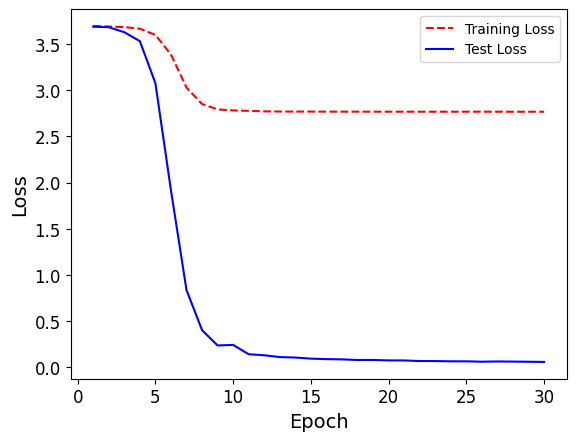

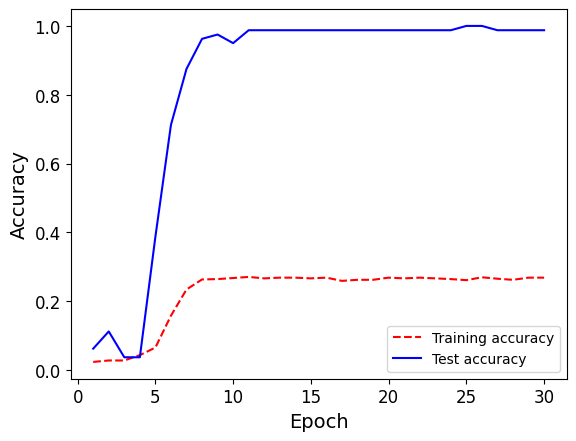

In [39]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

---

    1.b Análisis de regularización.

Siguiendo los consejos de Karpathy "Overfit and then Regularize", tomamos el modelo 4 y exploramos las opciones de regularización.

- Con dropout

In [40]:
model4b = Sequential()
# agregamos capas
model4b.add(Conv2D(32, kernel_size=2, activation="relu"))
model4b.add(Conv2D(64, kernel_size=4, activation="relu"))
model4b.add(Dropout(0.5))
model4b.add(MaxPool2D(pool_size=4))
model4b.add(Flatten())
model4b.add(Dense(40, activation="softmax"))

model4b.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model4b.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=30,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

Epoch 1/30
30/30 - 7s - loss: 3.7020 - accuracy: 0.0177 - val_loss: 3.6889 - val_accuracy: 0.0250 - 7s/epoch - 248ms/step
Epoch 2/30
30/30 - 6s - loss: 3.6892 - accuracy: 0.0146 - val_loss: 3.6889 - val_accuracy: 0.0250 - 6s/epoch - 202ms/step
Epoch 3/30
30/30 - 8s - loss: 3.6892 - accuracy: 0.0156 - val_loss: 3.6889 - val_accuracy: 0.0250 - 8s/epoch - 272ms/step
Epoch 4/30
30/30 - 9s - loss: 3.6892 - accuracy: 0.0188 - val_loss: 3.6888 - val_accuracy: 0.0250 - 9s/epoch - 316ms/step
Epoch 5/30
30/30 - 9s - loss: 3.6884 - accuracy: 0.0344 - val_loss: 3.6835 - val_accuracy: 0.0750 - 9s/epoch - 311ms/step
Epoch 6/30
30/30 - 9s - loss: 3.6888 - accuracy: 0.0292 - val_loss: 3.6888 - val_accuracy: 0.0375 - 9s/epoch - 289ms/step
Epoch 7/30
30/30 - 9s - loss: 3.6882 - accuracy: 0.0188 - val_loss: 3.6790 - val_accuracy: 0.1500 - 9s/epoch - 285ms/step
Epoch 8/30
30/30 - 9s - loss: 3.6791 - accuracy: 0.0573 - val_loss: 3.6722 - val_accuracy: 0.2125 - 9s/epoch - 289ms/step
Epoch 9/30
30/30 - 9s - 

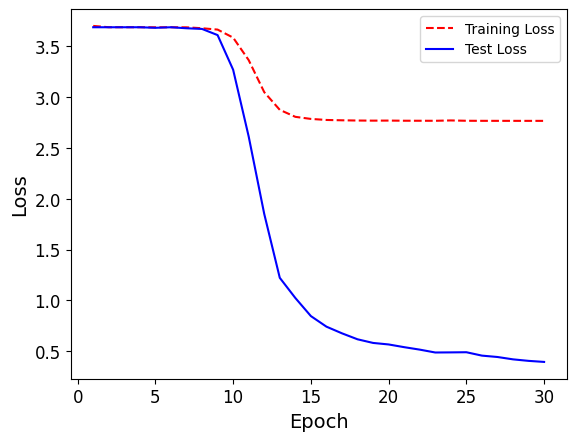

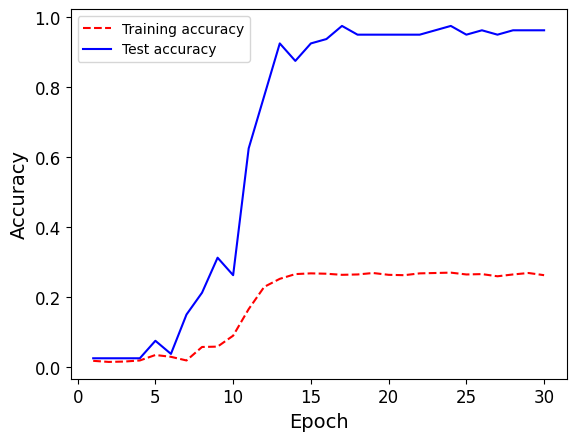

In [41]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

- Variando la intensidad de la regularización L2

In [42]:
model4c = Sequential()
# agregamos capas
model4c.add(Conv2D(32, kernel_size=2, activation="relu", kernel_regularizer =tf.keras.regularizers.l2(l=0.04)))
model4c.add(Conv2D(64, kernel_size=4, activation="relu",  kernel_regularizer =tf.keras.regularizers.l2(l=0.04)))
model4c.add(MaxPool2D(pool_size=4))
model4c.add(Flatten())
model4c.add(Dense(40, activation="softmax"))

model4c.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model4c.fit(X_train_convnet, y_train_convnet, validation_data=(X_val_convnet, y_val_convnet), epochs=38,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

Epoch 1/38
30/30 - 7s - loss: 4.7066 - accuracy: 0.0156 - val_loss: 4.1294 - val_accuracy: 0.1500 - 7s/epoch - 246ms/step
Epoch 2/38
30/30 - 6s - loss: 3.9280 - accuracy: 0.0250 - val_loss: 3.7909 - val_accuracy: 0.1000 - 6s/epoch - 201ms/step
Epoch 3/38
30/30 - 6s - loss: 3.7569 - accuracy: 0.0406 - val_loss: 3.7186 - val_accuracy: 0.0625 - 6s/epoch - 200ms/step
Epoch 4/38
30/30 - 5s - loss: 3.7169 - accuracy: 0.0458 - val_loss: 3.6839 - val_accuracy: 0.0375 - 5s/epoch - 179ms/step
Epoch 5/38
30/30 - 6s - loss: 3.7018 - accuracy: 0.0229 - val_loss: 3.6419 - val_accuracy: 0.0250 - 6s/epoch - 192ms/step
Epoch 6/38
30/30 - 5s - loss: 3.6869 - accuracy: 0.0417 - val_loss: 3.6065 - val_accuracy: 0.2500 - 5s/epoch - 183ms/step
Epoch 7/38
30/30 - 6s - loss: 3.6609 - accuracy: 0.0635 - val_loss: 3.4213 - val_accuracy: 0.4125 - 6s/epoch - 203ms/step
Epoch 8/38
30/30 - 6s - loss: 3.6040 - accuracy: 0.1281 - val_loss: 3.0043 - val_accuracy: 0.6000 - 6s/epoch - 187ms/step
Epoch 9/38
30/30 - 5s - 

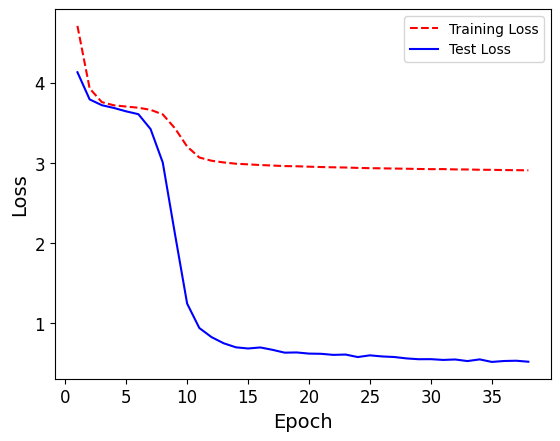

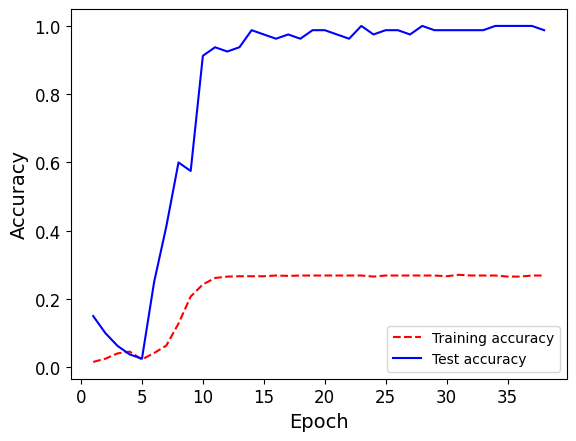

In [43]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Elegimos este último modelo, y lo exportamos en un pickle.

In [44]:
with open("model_cnn.pkl","wb") as f:
    pickle.dump(model4c,f)

---

    2.c Utilizando CNN pre-entrenada.

In [45]:
from keras.applications import vgg16

# Importamos vgg16 sin las capas superiores (totalmente conectadas)
vgg = vgg16.VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (64, 64, 3)) ##

# Congelamos las capas
for layer in vgg.layers:
    layer.trainable = False

# Imprimimos las capas del modelo y el estado "True" or "False" de capacidad de entrenar las capas
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)




58889256/58889256 [==============================] - 22s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False


In [46]:
# Definimos un nuevo modelo con las capas inferiores entrenadas y capas densas superiores a entrenar con nuestros datos

def newmodel(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(num_classes,activation='softmax')(top_model)
    return top_model


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

FC_Head = newmodel(vgg, 40)

model_pretrained1 = Model(inputs = vgg.input, outputs = FC_Head)

#print(model.summary())

for (i,layer) in enumerate(model_pretrained1.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)

0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 MaxPooling2D False
11 Conv2D False
12 Conv2D False
13 Conv2D False
14 MaxPooling2D False
15 Conv2D False
16 Conv2D False
17 Conv2D False
18 MaxPooling2D False
19 GlobalAveragePooling2D True
20 Dense True
21 Dense True


In [47]:
# Aqui arriba vemos que las capas densas tienen capacidad de ser entrenadas.

In [48]:
X_train_convnet_3 = np.stack((X_train_convnet.reshape(960,64,64),)*3, axis=-1)
X_val_convnet_3 = np.stack((X_val_convnet.reshape(80,64,64),)*3, axis=-1)
X_test_convnet_3 = np.stack((X_test_convnet.reshape(80,64,64),)*3, axis=-1)

In [49]:
# Entrenamos

model_pretrained1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model_pretrained1.fit(X_train_convnet_3, y_train_convnet, validation_data=(X_val_convnet_3, y_val_convnet), epochs=50,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']


Epoch 1/50
30/30 - 9s - loss: 3.7997 - accuracy: 0.0302 - val_loss: 3.2360 - val_accuracy: 0.1750 - 9s/epoch - 294ms/step
Epoch 2/50
30/30 - 6s - loss: 3.5732 - accuracy: 0.0823 - val_loss: 2.6152 - val_accuracy: 0.5125 - 6s/epoch - 206ms/step
Epoch 3/50
30/30 - 6s - loss: 3.3997 - accuracy: 0.1625 - val_loss: 2.0979 - val_accuracy: 0.6875 - 6s/epoch - 215ms/step
Epoch 4/50
30/30 - 7s - loss: 3.2702 - accuracy: 0.1927 - val_loss: 1.7480 - val_accuracy: 0.6375 - 7s/epoch - 228ms/step
Epoch 5/50
30/30 - 7s - loss: 3.1749 - accuracy: 0.2104 - val_loss: 1.3908 - val_accuracy: 0.7625 - 7s/epoch - 218ms/step
Epoch 6/50
30/30 - 7s - loss: 3.0898 - accuracy: 0.2240 - val_loss: 1.1590 - val_accuracy: 0.8000 - 7s/epoch - 235ms/step
Epoch 7/50
30/30 - 7s - loss: 3.0258 - accuracy: 0.2396 - val_loss: 1.0179 - val_accuracy: 0.7625 - 7s/epoch - 220ms/step
Epoch 8/50
30/30 - 7s - loss: 2.9835 - accuracy: 0.2375 - val_loss: 0.8878 - val_accuracy: 0.8500 - 7s/epoch - 231ms/step
Epoch 9/50
30/30 - 7s - 

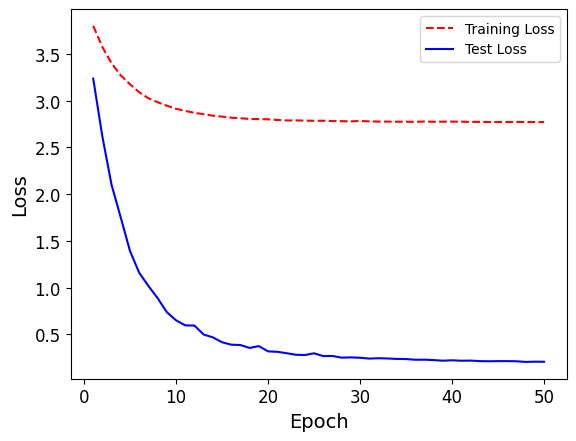

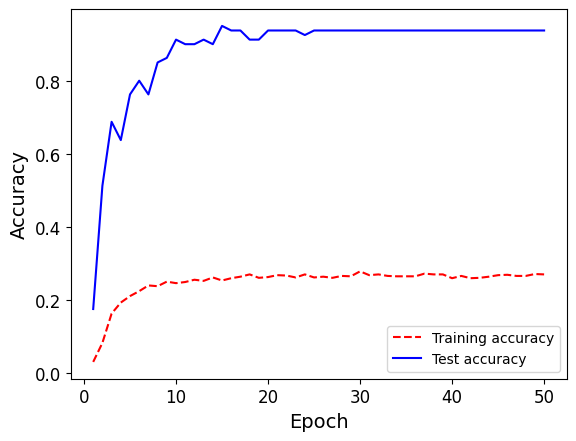

In [50]:
# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

Agregamos una capa densa más

Epoch 1/50
30/30 - 8s - loss: 3.7730 - accuracy: 0.0333 - val_loss: 3.4708 - val_accuracy: 0.1750 - 8s/epoch - 273ms/step
Epoch 2/50
30/30 - 7s - loss: 3.5892 - accuracy: 0.0781 - val_loss: 2.7192 - val_accuracy: 0.4500 - 7s/epoch - 239ms/step
Epoch 3/50
30/30 - 7s - loss: 3.3787 - accuracy: 0.1219 - val_loss: 1.9909 - val_accuracy: 0.5000 - 7s/epoch - 227ms/step
Epoch 4/50
30/30 - 7s - loss: 3.1890 - accuracy: 0.1469 - val_loss: 1.6775 - val_accuracy: 0.4750 - 7s/epoch - 238ms/step
Epoch 5/50
30/30 - 7s - loss: 3.0691 - accuracy: 0.1906 - val_loss: 0.9942 - val_accuracy: 0.7625 - 7s/epoch - 225ms/step
Epoch 6/50
30/30 - 7s - loss: 2.9751 - accuracy: 0.2104 - val_loss: 0.7996 - val_accuracy: 0.7750 - 7s/epoch - 233ms/step
Epoch 7/50
30/30 - 7s - loss: 2.9203 - accuracy: 0.2438 - val_loss: 0.7271 - val_accuracy: 0.7375 - 7s/epoch - 227ms/step
Epoch 8/50
30/30 - 7s - loss: 2.8802 - accuracy: 0.2323 - val_loss: 0.5632 - val_accuracy: 0.8000 - 7s/epoch - 237ms/step
Epoch 9/50
30/30 - 7s - 

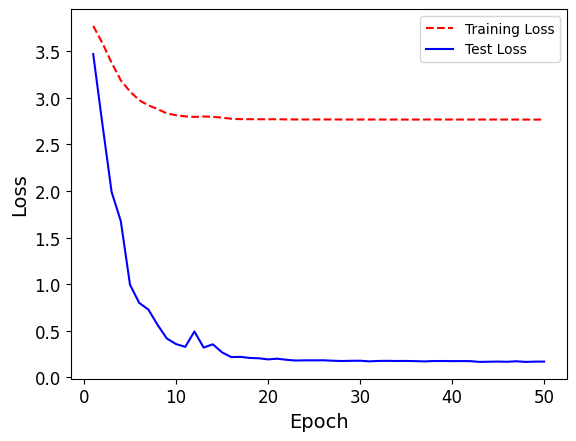

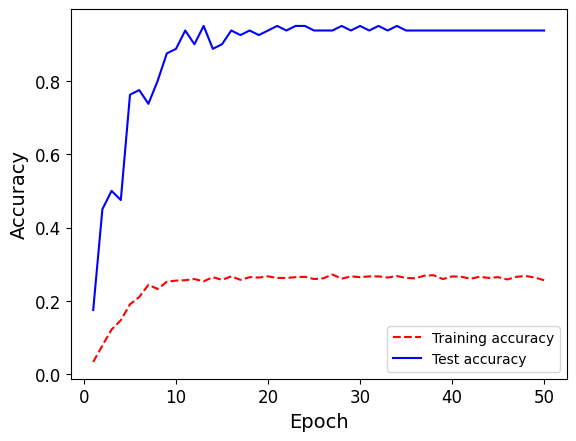

In [51]:
# Definimos un nuevo modelo con las capas inferiores entrenadas y capas densas superiores a entrenar con nuestros datos

def newmodel(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(1024,activation='relu')(top_model)
    top_model = Dense(40,activation='softmax')(top_model)
    return top_model


from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.models import Model

FC_Head = newmodel(vgg, 40)

model_pretrained2 = Model(inputs = vgg.input, outputs = FC_Head)

model_pretrained2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

tf.random.set_seed(111)
history = model_pretrained2.fit(X_train_convnet_3, y_train_convnet, validation_data=(X_val_convnet_3, y_val_convnet), epochs=50,verbose=2)

# historias de cada uno de los indicadores
training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# vector de epochs
epoch_count = range(1, len(training_loss) + 1)

# Historia de loss
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

# Historia de acc
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training accuracy', 'Test accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Elegimos el primer modelo propuesto, lo exportamos en un pickle:

In [52]:
with open("model_cnn_pretrained.pkl","wb") as f:
    pickle.dump(model_pretrained1,f)

## 3. Test

Testeamos los modelos.

In [53]:
## Modelo "baseline" PCA + LogReg
y_predicted_test = model_pcalog.predict(X_test_2)

print("Validation accuracy: ",accuracy_score(y_test,y_predicted_test))

print(sklearn.metrics.classification_report(y_test,y_predicted_test,digits=4))

Validation accuracy:  0.3125
              precision    recall  f1-score   support

           0     0.5000    0.5000    0.5000         2
           1     0.0000    0.0000    0.0000         2
           2     0.2500    0.5000    0.3333         2
           3     0.0000    0.0000    0.0000         2
           4     0.0000    0.0000    0.0000         2
           5     0.0000    0.0000    0.0000         2
           6     1.0000    0.5000    0.6667         2
           7     1.0000    0.5000    0.6667         2
           8     0.5000    0.5000    0.5000         2
           9     0.0000    0.0000    0.0000         2
          10     0.0000    0.0000    0.0000         2
          11     1.0000    1.0000    1.0000         2
          12     0.3333    0.5000    0.4000         2
          13     0.0000    0.0000    0.0000         2
          14     0.3333    0.5000    0.4000         2
          15     0.0000    0.0000    0.0000         2
          16     0.0000    0.0000    0.0000         

c:\Users\Ignacio Lembo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ignacio Lembo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Ignacio Lembo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

Observamos que el resultado de exactitud se condice con el análisis de Monte Carlo realizado previamente.

In [54]:
## Modelo ConvNet versión hand-crafted.

y_predicted_test = model4c.predict(X_test_convnet)
y_predicted_test = np.argmax(y_predicted_test,axis=1)

print("Validation accuracy: ",accuracy_score(y_test,y_predicted_test))

print(sklearn.metrics.classification_report(y_test,y_predicted_test,digits=4))

3/3 [==============================] - 0s 22ms/step
Validation accuracy:  0.95
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         2
           3     1.0000    0.5000    0.6667         2
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         2
           6     1.0000    1.0000    1.0000         2
           7     0.6667    1.0000    0.8000         2
           8     1.0000    1.0000    1.0000         2
           9     1.0000    0.5000    0.6667         2
          10     1.0000    1.0000    1.0000         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    1.0000    1.0000         2
          13     1.0000    1.0000    1.0000         2
          14     0.6667    1.0000    0.8000         2
          15     1.0000    1.0000    1.0000         2
  

In [55]:
## Modelo ConvNet versión pre-entrenado

y_predicted_test = model_pretrained1.predict(X_test_convnet_3)
y_predicted_test = np.argmax(y_predicted_test,axis=1)

print("Validation accuracy: ",accuracy_score(y_test,y_predicted_test))

print(sklearn.metrics.classification_report(y_test,y_predicted_test,digits=4))

3/3 [==============================] - 1s 136ms/step
Validation accuracy:  0.95
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000         2
           2     1.0000    1.0000    1.0000         2
           3     1.0000    1.0000    1.0000         2
           4     1.0000    1.0000    1.0000         2
           5     1.0000    1.0000    1.0000         2
           6     1.0000    0.5000    0.6667         2
           7     0.6667    1.0000    0.8000         2
           8     1.0000    1.0000    1.0000         2
           9     1.0000    0.5000    0.6667         2
          10     1.0000    1.0000    1.0000         2
          11     1.0000    1.0000    1.0000         2
          12     1.0000    1.0000    1.0000         2
          13     1.0000    1.0000    1.0000         2
          14     1.0000    1.0000    1.0000         2
          15     1.0000    0.5000    0.6667         2
 

## 4. Conclusiones

- Realizamos dos tipos de modelos alternativos para la resolución del problema de clasificación de caras: PCA + LogReg y ConvNets
- En ambos casos realizamos aumentación de datos para entrenar el modelo.
- Además, en el caso de las CNN exploramos la posibilidad de utilizar modelos pre-entrenados.
- Dentro de los modelos generados, el modelo CNN "hand-crafted" fue el que mejores resultados arrojó (1 solo error de clasificación en las 80 caras de test).